# Faster Polynomial Features

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Polynomial Features

The current implementation of [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) (0.20.2) implements a term by term product for each pair $X_i, X_j$ of features where $i \leqslant j$ which is not the most efficient way to do it.

In [3]:
import numpy.random
X = numpy.random.random((100, 5))

In [4]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
Xpoly = poly.fit_transform(X)
poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x3^2',
 'x3 x4',
 'x4^2']

In [5]:
%timeit poly.transform(X)

217 µs ± 5.22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


The class [ExtendedFeatures](http://www.xavierdupre.fr/app/mlinsights/helpsphinx/mlinsights/mlmodel/extended_features.html) implements a different way to compute the polynomial features as it tries to reduce the number of calls to numpy by using broacasted vector multplications.

In [6]:
from mlinsights.mlmodel import ExtendedFeatures
ext = ExtendedFeatures(poly_degree=2)
Xpoly = ext.fit_transform(X)
ext.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x3^2',
 'x3 x4',
 'x4^2']

In [7]:
%timeit ext.transform(X)

83.1 µs ± 6.94 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Comparison with 5 features

In [8]:
from cpyquickhelper.numbers import measure_time

In [9]:
res = []
for n in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 
          5000, 10000, 20000, 50000, 100000, 200000]:
    X = numpy.random.random((n, 5))
    poly.fit(X)
    ext.fit(X)
    r1 = measure_time("poly.transform(X)", context=dict(X=X, poly=poly), repeat=5, number=10, div_by_number=True)
    r2 = measure_time("ext.transform(X)", context=dict(X=X, ext=ext), repeat=5, number=10, div_by_number=True)
    r3 = measure_time("poly.fit_transform(X)", context=dict(X=X, poly=poly), repeat=5, number=10, div_by_number=True)
    r4 = measure_time("ext.fit_transform(X)", context=dict(X=X, ext=ext), repeat=5, number=10, div_by_number=True)
    r1["name"] = "poly"
    r2["name"] = "ext"
    r3["name"] = "poly+fit"
    r4["name"] = "ext+fit"
    r1["size"] = n
    r2["size"] = n
    r3["size"] = n
    r4["size"] = n
    res.append(r1)
    res.append(r2)
    res.append(r3)
    res.append(r4)
    
import pandas
df = pandas.DataFrame(res)
df.tail()

,average,context_size,deviation,max_exec,min_exec,name,number,repeat,size
63,0.037220,240,0.000338,0.037719,0.036767,ext+fit,10,5,100000
64,0.167729,240,0.014099,0.180496,0.141738,poly,10,5,200000
65,0.086990,240,0.009761,0.105847,0.077525,ext,10,5,200000
66,0.142285,240,0.002584,0.145134,0.138621,poly+fit,10,5,200000
67,0.074952,240,0.000851,0.075943,0.073507,ext+fit,10,5,200000


In [10]:
piv = df.pivot("size", "name", "average")
piv[:5]

name,ext,ext+fit,poly,poly+fit
size,,,,
1,0.000056,0.000146,0.000301,0.000248
2,0.000059,0.000141,0.000197,0.000230
5,0.000073,0.000234,0.000232,0.000239
10,0.000061,0.000196,0.000211,0.000243
20,0.000061,0.000147,0.000199,0.000242


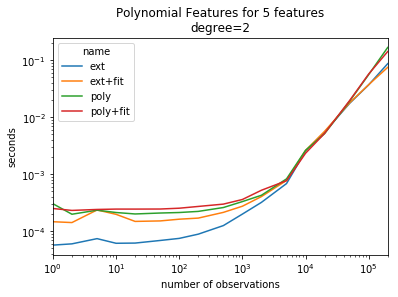

In [11]:
ax = piv.plot(logy=True, logx=True)
ax.set_title("Polynomial Features for 5 features\ndegree=2")
ax.set_ylabel("seconds")
ax.set_xlabel("number of observations");

The gain is mostly visible for small dimensions.

## Comparison with 1000 observations

In this experiment, the number of observations is fixed to 1000 but the number of features varies.

In [12]:
res = []
for n in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 40, 50]:
    X = numpy.random.random((1000, n))
    poly.fit(X)
    ext.fit(X)
    r1 = measure_time("poly.transform(X)", context=dict(X=X, poly=poly), repeat=5, number=30, div_by_number=True)
    r2 = measure_time("ext.transform(X)", context=dict(X=X, ext=ext), repeat=5, number=30, div_by_number=True)
    r1["name"] = "poly"
    r2["name"] = "ext"
    r1["nfeat"] = n
    r2["nfeat"] = n
    x1 = poly.transform(X)
    x2 = ext.transform(X)
    r1["numf"] = x1.shape[1]
    r2["numf"] = x2.shape[1]
    res.append(r1)
    res.append(r2)
    
import pandas
df = pandas.DataFrame(res)
df.tail()

,average,context_size,deviation,max_exec,min_exec,name,nfeat,number,numf,repeat
23,0.002114,240,0.000031,0.002158,0.002067,ext,20,30,231,5
24,0.017428,240,0.001216,0.019226,0.016013,poly,40,30,861,5
25,0.007739,240,0.000212,0.008048,0.007455,ext,40,30,861,5
26,0.025313,240,0.000227,0.025564,0.024994,poly,50,30,1326,5
27,0.011607,240,0.000098,0.011721,0.011469,ext,50,30,1326,5


In [13]:
piv = df.pivot("nfeat", "name", "average")
piv[:5]

name,ext,poly
nfeat,,
1,0.000070,0.000186
2,0.000094,0.000183
3,0.000119,0.000189
4,0.000150,0.000243
5,0.000192,0.000325


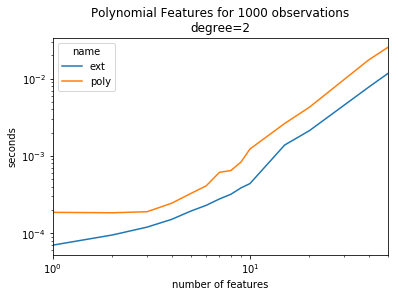

In [14]:
ax = piv.plot(logy=True, logx=True)
ax.set_title("Polynomial Features for 1000 observations\ndegree=2")
ax.set_ylabel("seconds")
ax.set_xlabel("number of features");

It is faster by a short amount of time.

## Comparison for different degrees

In this experiment, the number of observations and features is fixed, the degree increases. Since dense matrix is usually organized by rows in memory, I was curious to know if there would be an even better gain by computing the polynomial features on the transposed matrix.

In [15]:
res = []
for n in [2, 3, 4, 5, 6, 7, 8]:
    X = numpy.random.random((1000, 4))
    poly = PolynomialFeatures(degree=n)
    ext = ExtendedFeatures(poly_degree=n)
    exttr = ExtendedFeatures(poly_degree=n, poly_transpose=True)
    poly.fit(X)
    ext.fit(X)
    exttr.fit(X)
    r1 = measure_time("poly.transform(X)", context=dict(X=X, poly=poly), repeat=5, number=30, div_by_number=True)
    r2 = measure_time("ext.transform(X)", context=dict(X=X, ext=ext), repeat=5, number=30, div_by_number=True)
    r3 = measure_time("exttr.transform(X)", context=dict(X=X, exttr=exttr), repeat=5, number=30, div_by_number=True)
    r1["name"] = "poly"
    r2["name"] = "ext"
    r3["name"] = "exttr"
    r1["degree"] = n
    r2["degree"] = n
    r3["degree"] = n
    x1 = poly.transform(X)
    x2 = ext.transform(X)
    x3 = exttr.transform(X)
    r1["numf"] = x1.shape[1]
    r2["numf"] = x2.shape[1]
    r3["numf"] = x3.shape[1]
    res.append(r1)
    res.append(r2)
    res.append(r3)
    
import pandas
df = pandas.DataFrame(res)
df.tail()

,average,context_size,degree,deviation,max_exec,min_exec,name,number,numf,repeat
16,0.002916,240,7,0.000102,0.003083,0.002800,ext,30,330,5
17,0.002177,240,7,0.000038,0.002242,0.002125,exttr,30,330,5
18,0.010794,240,8,0.000265,0.011271,0.010499,poly,30,495,5
19,0.004173,240,8,0.000050,0.004266,0.004129,ext,30,495,5
20,0.003267,240,8,0.000047,0.003347,0.003200,exttr,30,495,5


In [16]:
piv = df.pivot("degree", "name", "average")
piv[:5]

name,ext,exttr,poly
degree,,,
2,0.000214,0.000085,0.000451
3,0.000299,0.000115,0.000544
4,0.000496,0.000174,0.001125
5,0.000688,0.000256,0.001926
6,0.001880,0.001407,0.004316


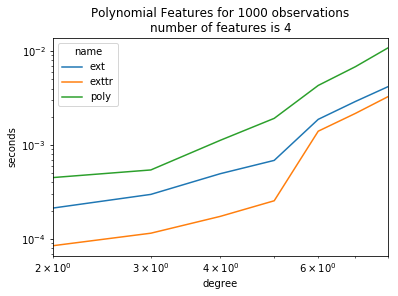

In [17]:
ax = piv.plot(logy=True, logx=True)
ax.set_title("Polynomial Features for 1000 observations\nnumber of features is 4")
ax.set_ylabel("seconds")
ax.set_xlabel("degree");

It is worth transposing.

## First test with transpose but interaction_only=True

In [18]:
res = []
for n in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 
          5000, 10000, 20000, 50000, 100000, 200000]:
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    ext = ExtendedFeatures(poly_degree=2, poly_transpose=False, poly_interaction_only=True)
    exttr = ExtendedFeatures(poly_degree=2, poly_transpose=True, poly_interaction_only=True)
    X = numpy.random.random((n, 5))
    poly.fit(X)
    ext.fit(X)
    exttr.fit(X)
    r1 = measure_time("poly.transform(X)", context=dict(X=X, poly=poly), repeat=2, number=30, div_by_number=True)
    r2 = measure_time("ext.transform(X)", context=dict(X=X, ext=ext), repeat=2, number=30, div_by_number=True)
    r3 = measure_time("exttr.transform(X)", context=dict(X=X, exttr=exttr), repeat=2, number=30, div_by_number=True)
    r1["name"] = "poly"
    r2["name"] = "ext"
    r3["name"] = "exttr"
    r1["size"] = n
    r2["size"] = n
    r3["size"] = n
    res.append(r1)
    res.append(r2)
    res.append(r3)
    
import pandas
df = pandas.DataFrame(res)
df.tail()

,average,context_size,deviation,max_exec,min_exec,name,number,repeat,size
46,0.025628,240,0.000066,0.025694,0.025562,ext,30,2,100000
47,0.014328,240,0.000170,0.014498,0.014158,exttr,30,2,100000
48,0.107978,240,0.004430,0.112409,0.103548,poly,30,2,200000
49,0.053047,240,0.000235,0.053282,0.052812,ext,30,2,200000
50,0.030080,240,0.000105,0.030185,0.029975,exttr,30,2,200000


In [19]:
piv = df.pivot("size", "name", "average")
piv[:5]

name,ext,exttr,poly
size,,,
1,0.000085,0.000150,0.000487
2,0.000057,0.000096,0.000213
5,0.000071,0.000056,0.000168
10,0.000060,0.000055,0.000176
20,0.000097,0.000087,0.000214


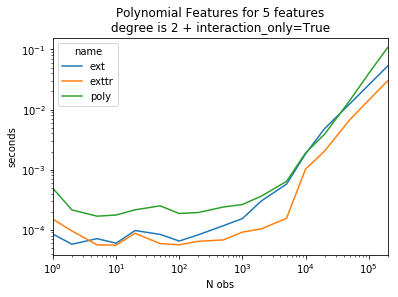

In [20]:
ax = piv.plot(logy=True, logx=True)
ax.set_title("Polynomial Features for 5 features\ndegree is 2 + interaction_only=True")
ax.set_ylabel("seconds")
ax.set_xlabel("N obs");

## Sparse...

A new implementation was introduced at the end of 2018 to compute polynomial features for CSR sparse matrices. It is enabled for degree 2 and 3. Let's see how it compares against the new version.

In [21]:
from scipy.sparse import csr_matrix

poly = PolynomialFeatures(degree=2)
ext = ExtendedFeatures(poly_degree=2, poly_transpose=False)
exttr = ExtendedFeatures(poly_degree=2, poly_transpose=True)

def poly_transform_csr(poly, x):
    csr = csr_matrix(x)
    res = poly.transform(csr)
    return res.todense()

res = []
for n in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 
          5000, 10000, 20000, 50000, 100000, 200000]:
    X = numpy.random.random((n, 5))
    poly.fit(X)
    ext.fit(X)
    exttr.fit(X)
    r1 = measure_time("poly.transform(X)", context=dict(X=X, poly=poly), repeat=2, number=30, div_by_number=True)
    r2 = measure_time("ext.transform(X)", context=dict(X=X, ext=ext), repeat=2, number=30, div_by_number=True)
    r3 = measure_time("exttr.transform(X)", context=dict(X=X, exttr=exttr), repeat=2, number=30, div_by_number=True)
    r4 = measure_time("poly_transform_csr(poly, X)", context=dict(X=X, poly=poly, poly_transform_csr=poly_transform_csr),
                      repeat=2, number=30, div_by_number=True)
    r1["name"] = "poly"
    r2["name"] = "ext"
    r3["name"] = "exttr"
    r4["name"] = "poly_csr"
    r1["size"] = n
    r2["size"] = n
    r3["size"] = n
    r4["size"] = n
    res.append(r1)
    res.append(r2)
    res.append(r3)
    res.append(r4)
    
import pandas
df = pandas.DataFrame(res)
df.tail()

,average,context_size,deviation,max_exec,min_exec,name,number,repeat,size
63,0.175664,240,0.011941,0.187605,0.163722,poly_csr,30,2,100000
64,0.140857,240,0.000496,0.141353,0.140361,poly,30,2,200000
65,0.075280,240,0.000124,0.075403,0.075156,ext,30,2,200000
66,0.041768,240,0.000132,0.041900,0.041636,exttr,30,2,200000
67,0.329876,240,0.000064,0.329940,0.329813,poly_csr,30,2,200000


In [22]:
piv = df.pivot("size", "name", "average")
piv[:5]

name,ext,exttr,poly,poly_csr
size,,,,
1,0.000077,0.000098,0.000277,0.000865
2,0.000059,0.000058,0.000206,0.000731
5,0.000061,0.000064,0.000211,0.000724
10,0.000066,0.000058,0.000207,0.000777
20,0.000061,0.000061,0.000215,0.000749


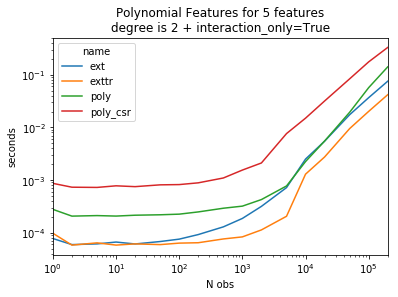

In [23]:
ax = piv.plot(logy=True, logx=True)
ax.set_title("Polynomial Features for 5 features\ndegree is 2 + interaction_only=True")
ax.set_ylabel("seconds")
ax.set_xlabel("N obs");

## Memory profiler

In [24]:
from memory_profiler import memory_usage
poly = PolynomialFeatures(degree=2, interaction_only=True)
poly.fit(X)
memory_usage((poly.transform, (X,)), interval=0.1, max_usage=True)

[1102.953125]

In [25]:
res = []
for n in [10000, 50000, 100000, 200000]:
    X = numpy.random.random((n, 50))
    print(n)
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    ext = ExtendedFeatures(poly_degree=2, poly_transpose=False)
    exttr = ExtendedFeatures(poly_degree=2, poly_transpose=True)
    poly.fit(X)
    ext.fit(X)
    exttr.fit(X)    
    r1 = memory_usage((poly.transform, (X,)), interval=0.1, max_usage=True)
    r2 = memory_usage((ext.transform, (X,)), interval=0.1, max_usage=True)
    r3 = memory_usage((exttr.transform, (X,)), interval=0.1, max_usage=True)
    r1 = {"memory": r1[0]}
    r2 = {"memory": r2[0]}
    r3 = {"memory": r3[0]}
    r1["name"] = "poly"
    r2["name"] = "ext"
    r3["name"] = "exttr"
    r1["size"] = n
    r2["size"] = n
    r3["size"] = n
    res.append(r1)
    res.append(r2)
    res.append(r3)
    
import pandas
df = pandas.DataFrame(res)
df.tail()

10000
50000
100000
200000


,memory,name,size
7,1128.476562,ext,100000
8,1107.878906,exttr,100000
9,2162.281250,poly,200000
10,2200.429688,ext,200000
11,2157.707031,exttr,200000


In [26]:
piv = df.pivot("size", "name", "memory")
piv[:5]

name,ext,exttr,poly
size,,,
10000,265.886719,254.496094,258.816406
50000,588.816406,582.441406,582.441406
100000,1128.476562,1107.878906,1109.160156
200000,2200.429688,2157.707031,2162.281250


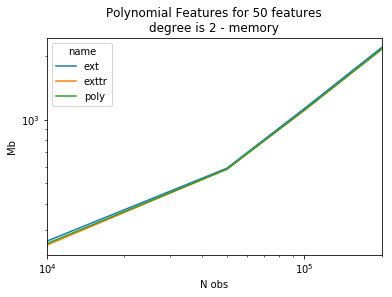

In [27]:
ax = piv.plot(logy=True, logx=True)
ax.set_title("Polynomial Features for 50 features\ndegree is 2 - memory")
ax.set_ylabel("Mb")
ax.set_xlabel("N obs");